# Preparing the Dataset

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import geopandas as gpd
import geoplot as gplt
from shapely.geometry import Point
import geoplot.crs as gcrs
import contextily as cx
from geopandas.tools import overlay
import mapclassify as mc
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Kept the original dataset
listingsNYC = pd.read_csv('listings.csv', dtype=object)
# Dropping all of the columns which we will not use
# listingsNYC= listingsNYC.drop(['last_review','license','latitude','longitude','host_name'], axis=1)

# Dropping all rows with any 'Nan' values in them
# listingsNYC.dropna(axis=0, how='any', inplace=True)
data_types_dict = {
    'price':'int64', 
    'minimum_nights':'int64', 
    'host_id':str,
    'number_of_reviews':'int64',
    'reviews_per_month':float,
    'calculated_host_listings_count':'int64',
    'availability_365':'int64',
    'number_of_reviews_ltm':'int64',
    'latitude':float,
    'longitude':float
}

#changing all the datatype to their respective types that we can work with
listingsNYC = listingsNYC.astype(data_types_dict)

# creating a price per stay (ppn) column with the price and minimim nights columns and rounding to 2 decimal places. 
# This is a float dtype 
listingsNYC['pps'] = (listingsNYC['price'] * listingsNYC['minimum_nights']).round(2)
listingsNYC['neighbourhood'].unique().shape[0]
listingsNYC.describe()
listingsNYC['annual_revenue'] = (365 - listingsNYC['availability_365']) *  listingsNYC['price']
listingsNYC = listingsNYC[(listingsNYC['price'] != 0)]
listingsNYC.loc[:,'log_price']=np.log(listingsNYC['price'])
listingsNYC.loc[:,'log_pps']=np.log(listingsNYC['pps'])
# listingsNYC['price_bin'] = pd.cut(listingsNYC['price'], bins=range(0, 111, 10), right=False, labels=range(0, 110, 10))
df = listingsNYC[(listingsNYC['price']<2000) & (listingsNYC['price']>20) & (listingsNYC['minimum_nights'] < 30)]
df['price_bin'] = pd.cut(df['price'], bins=range(0, 2001, 20), right=False, labels=range(0, 2000, 20))
df

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,pps,annual_revenue,log_price,log_pps,price_bin
0,5136,"Spacious Brooklyn Duplex, Patio + Garden",7378,Rebecca,Brooklyn,Sunset Park,40.662650,-73.994540,Entire home/apt,275,...,0.03,1,267,1,NaN,5775,26950,5.616771,8.661294,260
1,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.803800,-73.967510,Private room,75,...,0.73,1,0,0,NaN,150,27375,4.317488,5.010635,60
3,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Midtown,40.764570,-73.983170,Private room,68,...,3.38,1,79,50,NaN,136,19448,4.219508,4.912655,60
6,5803,"Lovely Room 1 in BEST AREA; Legal Rental, Spot...",9744,Laurie,Brooklyn,South Slope,40.668010,-73.987840,Private room,124,...,1.31,3,163,14,NaN,496,25048,4.820282,6.206576,120
8,7097,Perfect for Your Parents: Privacy + Garden,17571,Jane,Brooklyn,Fort Greene,40.691233,-73.972702,Entire home/apt,220,...,2.01,2,38,36,NaN,660,71940,5.393628,6.492240,220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41525,772714221060214808,Good Vibes at The Bronx,421264574,Aridio,Bronx,Unionport,40.828074,-73.847886,Entire home/apt,125,...,NaN,1,60,0,NaN,250,38125,4.828314,5.521461,120
41526,772716724205003579,2 bedroom Condo near West Village,481177884,Steven,Manhattan,Chelsea,40.740030,-73.997302,Entire home/apt,1114,...,NaN,2,355,0,NaN,3342,11140,7.015712,8.114325,1100
41527,771961589340472067,Habitación Privada,409771624,Camila,Queens,Sunnyside,40.742223,-73.923310,Private room,124,...,NaN,1,360,0,NaN,248,620,4.820282,5.513429,120
41528,771962449581256963,Romántico y natural,421601513,Juan Carlos,Manhattan,Washington Heights,40.847271,-73.943419,Private room,80,...,NaN,3,358,0,NaN,400,560,4.382027,5.991465,80


In [3]:
brooklyn = df[df['neighbourhood_group']=='Brooklyn']
manhattan = df[df['neighbourhood_group']=='Manhattan']
queens = df[df['neighbourhood_group']=='Queens']
bronx = df[df['neighbourhood_group']=='Bronx']
staten_island = df[df['neighbourhood_group']=='Staten Island']

In [4]:
brooklyn_price_bin_grouping_mean = brooklyn.groupby('price_bin').mean()
brooklyn_price_bin_grouping_count = brooklyn.groupby('price_bin').count()

manhattan_price_bin_grouping_mean = manhattan.groupby('price_bin').mean()
manhattan_price_bin_grouping_count = manhattan.groupby('price_bin').count()

queens_price_bin_grouping_mean = queens.groupby('price_bin').mean()
queens_price_bin_grouping_count = queens.groupby('price_bin').count()

bronx_price_bin_grouping_mean = bronx.groupby('price_bin').mean()
bronx_price_bin_grouping_count = bronx.groupby('price_bin').count()

staten_island_price_bin_grouping_mean = staten_island.groupby('price_bin').mean()
staten_island_price_bin_grouping_count = staten_island.groupby('price_bin').count()


In [5]:
brooklyn_price_bin_grouping_count = brooklyn_price_bin_grouping_count[['price']]
brooklyn_price_bin_grouping_count.rename(columns={'price':'price_bin_count'}, inplace=True)
brooklyn_price_bin_grouping = pd.merge(brooklyn_price_bin_grouping_mean,brooklyn_price_bin_grouping_count, how = 'left', on= 'price_bin')

manhattan_price_bin_grouping_count = manhattan_price_bin_grouping_count[['price']]
manhattan_price_bin_grouping_count.rename(columns={'price':'price_bin_count'}, inplace=True)
manhattan_price_bin_grouping = pd.merge(manhattan_price_bin_grouping_mean,manhattan_price_bin_grouping_count, how = 'left', on= 'price_bin')

queens_price_bin_grouping_count = queens_price_bin_grouping_count[['price']]
queens_price_bin_grouping_count.rename(columns={'price':'price_bin_count'}, inplace=True)
queens_price_bin_grouping = pd.merge(queens_price_bin_grouping_mean,queens_price_bin_grouping_count, how = 'left', on= 'price_bin')

bronx_price_bin_grouping_count = bronx_price_bin_grouping_count[['price']]
bronx_price_bin_grouping_count.rename(columns={'price':'price_bin_count'}, inplace=True)
bronx_price_bin_grouping = pd.merge(bronx_price_bin_grouping_mean,bronx_price_bin_grouping_count, how = 'left', on= 'price_bin')

staten_island_price_bin_grouping_count = staten_island_price_bin_grouping_count[['price']]
staten_island_price_bin_grouping_count.rename(columns={'price':'price_bin_count'}, inplace=True)
staten_island_price_bin_grouping = pd.merge(staten_island_price_bin_grouping_mean,staten_island_price_bin_grouping_count, how = 'left', on= 'price_bin')

In [6]:
sns.set_style({'axes.facecolor': 'white','axes.edgecolor': 'grey','axes.spines.right': False, 'axes.spines.top': False,'xtick.color': 'grey', 'ytick.color': 'grey'})

# brooklyn

<Axes: xlabel='price_bin', ylabel='annual_revenue'>

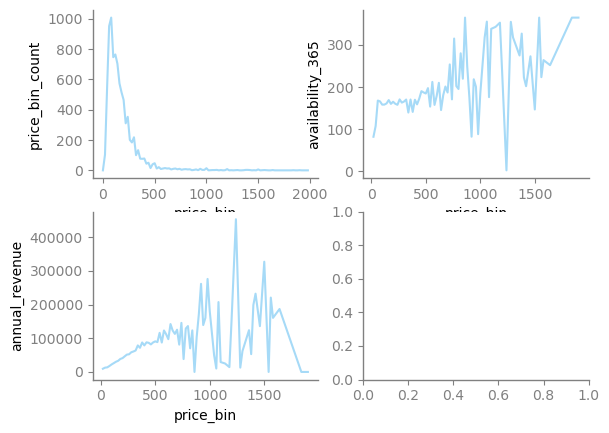

In [7]:
fig, axes = plt.subplots(2,2)
sns.lineplot(x = brooklyn_price_bin_grouping.index, y = 'price_bin_count', data=brooklyn_price_bin_grouping,ax=axes[0,0],color='#A6DAF7')
sns.lineplot(x = brooklyn_price_bin_grouping.index, y = 'availability_365', data=brooklyn_price_bin_grouping,ax=axes[0,1],color='#A6DAF7')
sns.lineplot(x = brooklyn_price_bin_grouping.index, y = 'annual_revenue', data=brooklyn_price_bin_grouping,ax=axes[1,0],color='#A6DAF7')


Text(0, 0.5, 'Number of Listings')

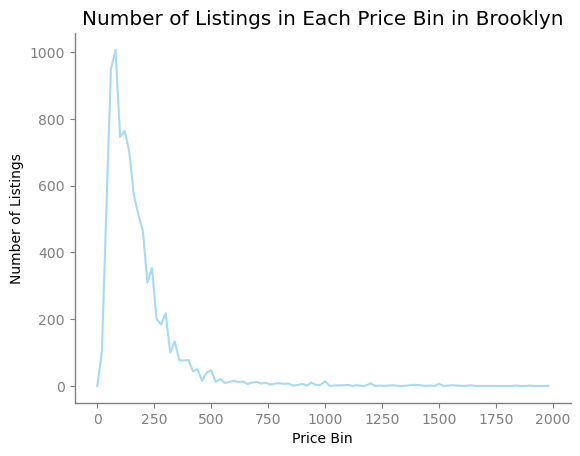

In [8]:
sns.lineplot(x = brooklyn_price_bin_grouping.index, y = 'price_bin_count', data=brooklyn_price_bin_grouping,color='#A6DAF7')
plt.title('Number of Listings in Each Price Bin in Brooklyn')
plt.xlabel('Price Bin')
plt.ylabel('Number of Listings')

Text(0, 0.5, 'Average Days Listing is not booked')

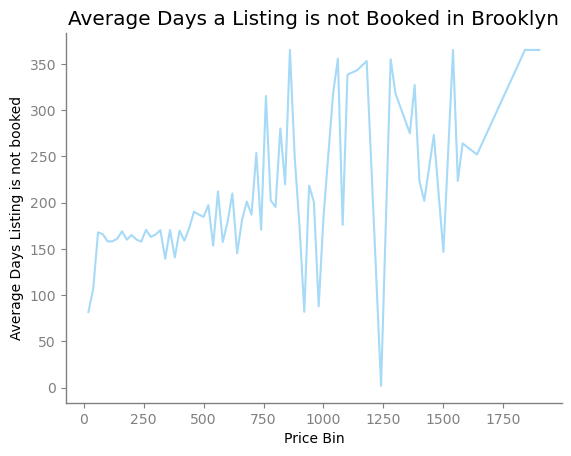

In [9]:
sns.lineplot(x = brooklyn_price_bin_grouping.index, y = 'availability_365', data=brooklyn_price_bin_grouping,color='#A6DAF7')
plt.title('Average Days a Listing is not Booked in Brooklyn')
plt.xlabel('Price Bin')
plt.ylabel('Average Days Listing is not booked')

Text(0, 0.5, 'Estimated Annual Revenue')

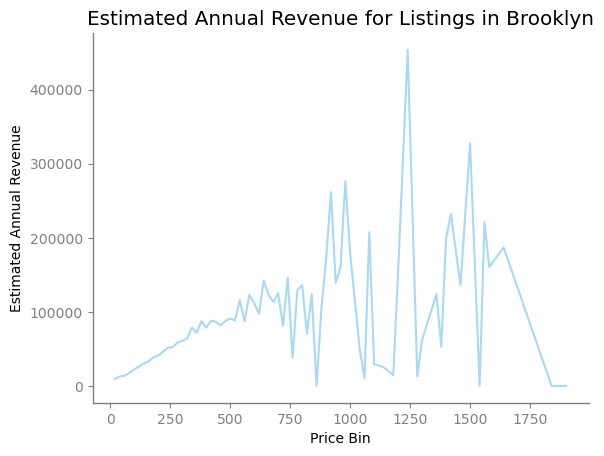

In [10]:
sns.lineplot(x = brooklyn_price_bin_grouping.index, y = 'annual_revenue', data=brooklyn_price_bin_grouping,color='#A6DAF7')
plt.title('Estimated Annual Revenue for Listings in Brooklyn')
plt.xlabel('Price Bin')
plt.ylabel('Estimated Annual Revenue')

# manhattan

<Axes: xlabel='price_bin', ylabel='annual_revenue'>

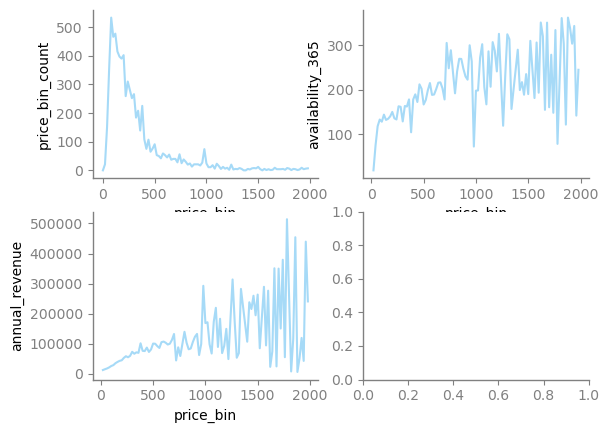

In [11]:
fig, axes = plt.subplots(2, 2)
sns.lineplot(x = brooklyn_price_bin_grouping.index, y = 'price_bin_count', data=manhattan_price_bin_grouping,ax=axes[0,0],color='#A6DAF7')
sns.lineplot(x = brooklyn_price_bin_grouping.index, y = 'availability_365', data=manhattan_price_bin_grouping,ax=axes[0,1],color='#A6DAF7')
sns.lineplot(x = brooklyn_price_bin_grouping.index, y = 'annual_revenue', data=manhattan_price_bin_grouping,ax=axes[1,0],color='#A6DAF7')


Text(0, 0.5, 'Number of Listings')

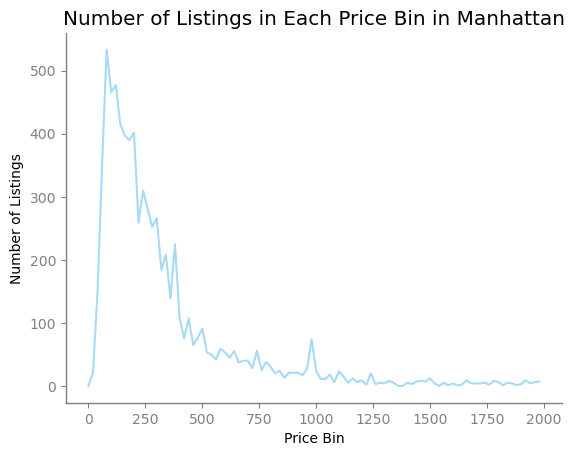

In [12]:
sns.lineplot(x = manhattan_price_bin_grouping.index, y = 'price_bin_count', data=manhattan_price_bin_grouping,color='#A6DAF7')
plt.title('Number of Listings in Each Price Bin in Manhattan')
plt.xlabel('Price Bin')
plt.ylabel('Number of Listings')

Text(0, 0.5, 'Average Days Listing is not booked')

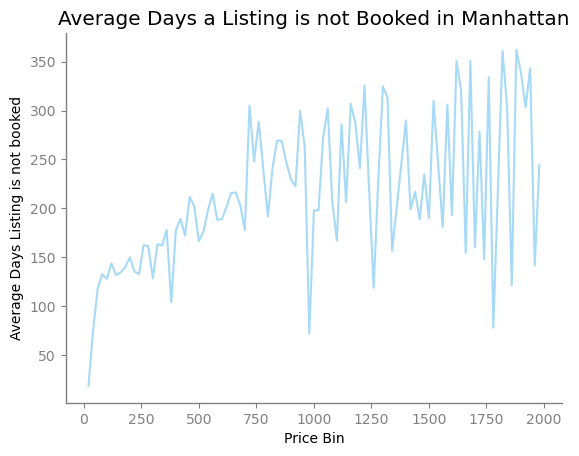

In [13]:
sns.lineplot(x = manhattan_price_bin_grouping.index, y = 'availability_365', data=manhattan_price_bin_grouping,color='#A6DAF7')
plt.title('Average Days a Listing is not Booked in Manhattan')
plt.xlabel('Price Bin')
plt.ylabel('Average Days Listing is not booked')

Text(0, 0.5, 'Estimated Annual Revenue')

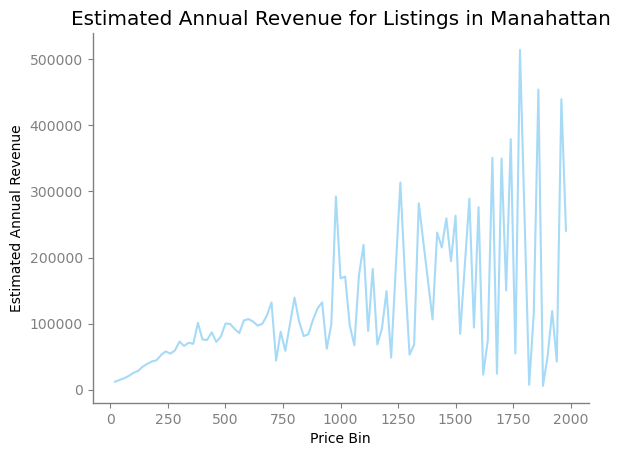

In [14]:
sns.lineplot(x = manhattan_price_bin_grouping.index, y = 'annual_revenue', data=manhattan_price_bin_grouping,color='#A6DAF7')
plt.title('Estimated Annual Revenue for Listings in Manahattan')
plt.xlabel('Price Bin')
plt.ylabel('Estimated Annual Revenue')

# queens

<Axes: xlabel='price_bin', ylabel='annual_revenue'>

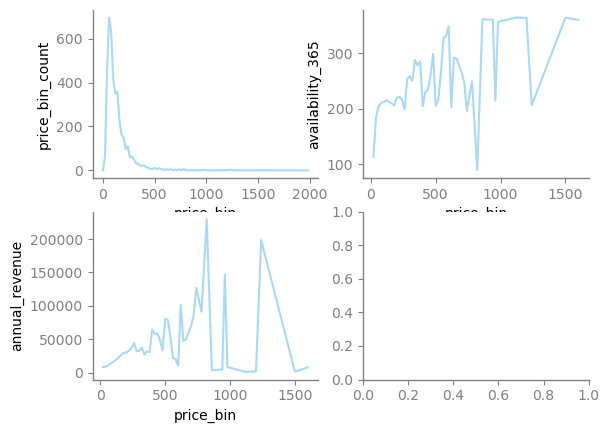

In [15]:
fig, axes = plt.subplots(2, 2)
sns.lineplot(x = brooklyn_price_bin_grouping.index, y = 'price_bin_count', data=queens_price_bin_grouping,ax=axes[0,0],color='#A6DAF7')
sns.lineplot(x = brooklyn_price_bin_grouping.index, y = 'availability_365', data=queens_price_bin_grouping,ax=axes[0,1],color='#A6DAF7')
sns.lineplot(x = brooklyn_price_bin_grouping.index, y = 'annual_revenue', data=queens_price_bin_grouping,ax=axes[1,0],color='#A6DAF7')


Text(0, 0.5, 'Number of Listings')

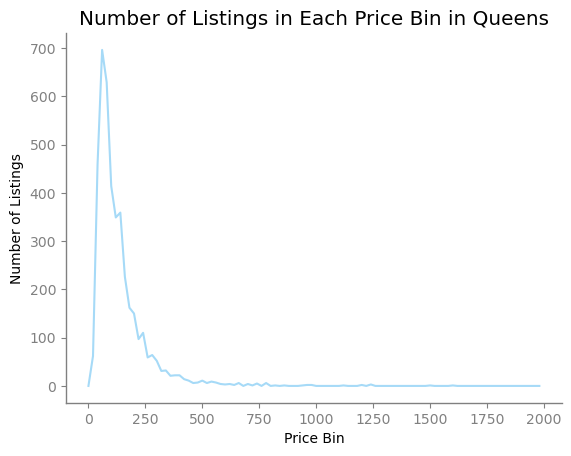

In [16]:
sns.lineplot(x = queens_price_bin_grouping.index, y = 'price_bin_count', data=queens_price_bin_grouping,color='#A6DAF7')
plt.title('Number of Listings in Each Price Bin in Queens')
plt.xlabel('Price Bin')
plt.ylabel('Number of Listings')

Text(0, 0.5, 'Average Days Listing is not booked')

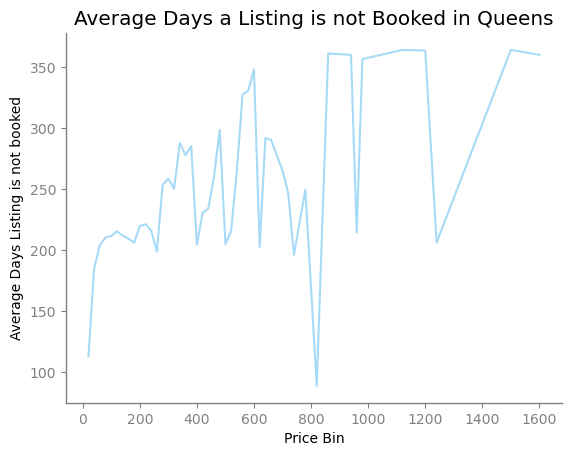

In [17]:
sns.lineplot(x = queens_price_bin_grouping.index, y = 'availability_365', data=queens_price_bin_grouping,color='#A6DAF7')
plt.title('Average Days a Listing is not Booked in Queens')
plt.xlabel('Price Bin')
plt.ylabel('Average Days Listing is not booked')

Text(0, 0.5, 'Estimated Annual Revenue')

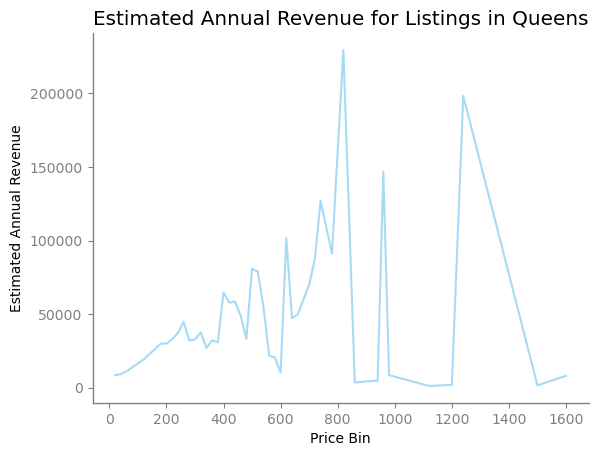

In [18]:
sns.lineplot(x = queens_price_bin_grouping.index, y = 'annual_revenue', data=queens_price_bin_grouping,color='#A6DAF7')
plt.title('Estimated Annual Revenue for Listings in Queens')
plt.xlabel('Price Bin')
plt.ylabel('Estimated Annual Revenue')

# the bronx

<Axes: xlabel='price_bin', ylabel='annual_revenue'>

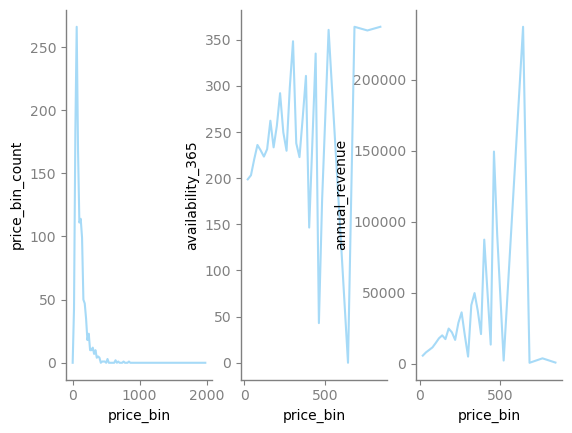

In [19]:
fig, axes = plt.subplots(1, 3)
sns.lineplot(x = brooklyn_price_bin_grouping.index, y = 'price_bin_count', data=bronx_price_bin_grouping,ax=axes[0],color='#A6DAF7')
sns.lineplot(x = brooklyn_price_bin_grouping.index, y = 'availability_365', data=bronx_price_bin_grouping,ax=axes[1],color='#A6DAF7')
sns.lineplot(x = brooklyn_price_bin_grouping.index, y = 'annual_revenue', data=bronx_price_bin_grouping,ax=axes[2],color='#A6DAF7')


Text(0, 0.5, 'Number of Listings')

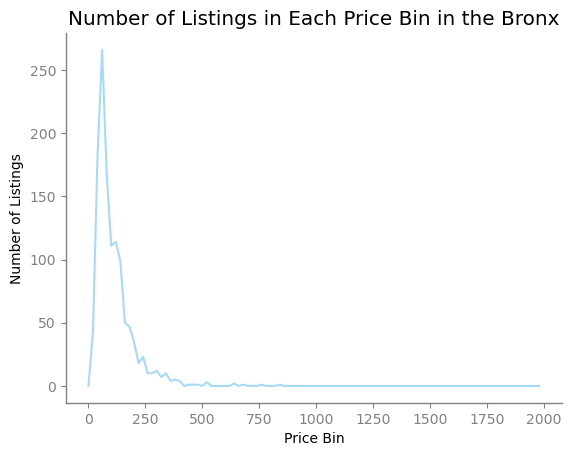

In [20]:
sns.lineplot(x = bronx_price_bin_grouping.index, y = 'price_bin_count', data=bronx_price_bin_grouping, color='#A6DAF7')
plt.title('Number of Listings in Each Price Bin in the Bronx')
plt.xlabel('Price Bin')
plt.ylabel('Number of Listings')

Text(0, 0.5, 'Average Days Listing is not booked')

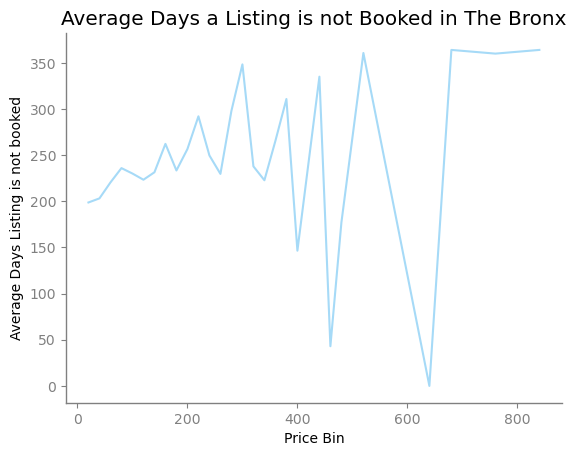

In [21]:
sns.lineplot(x = bronx_price_bin_grouping.index, y = 'availability_365', data=bronx_price_bin_grouping,color='#A6DAF7')
plt.title('Average Days a Listing is not Booked in The Bronx')
plt.xlabel('Price Bin')
plt.ylabel('Average Days Listing is not booked')

Text(0, 0.5, 'Estimated Annual Revenue')

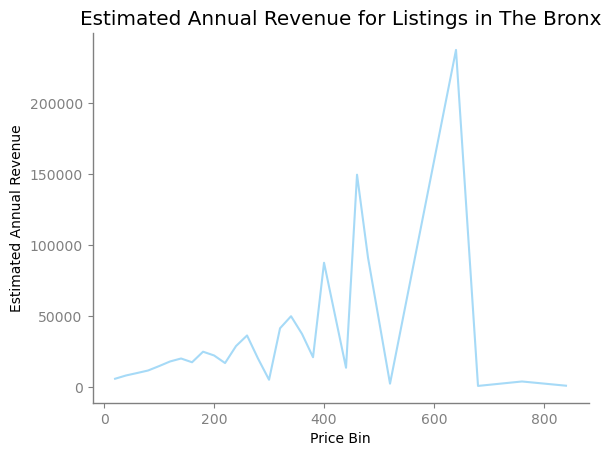

In [22]:
sns.lineplot(x = bronx_price_bin_grouping.index, y = 'annual_revenue', data=bronx_price_bin_grouping,color='#A6DAF7')
plt.title('Estimated Annual Revenue for Listings in The Bronx')
plt.xlabel('Price Bin')
plt.ylabel('Estimated Annual Revenue')

We can see that in the overall lineplot there is a small trend that the availability decreases until you hit the 250 price bin. Looking at the bronx availability, it seems that there may be a higher demand for lower priced listings. This is seem in the annual revenue lineplot where annual revenue is higher at the 200 price bin than the 250 price bin. Also in the availability plot, it shows that the lower price bins are in higher demand. This is different from the trend seens when all of the data points are plotted. Price bins after the $200 have a higher variance meaning there is more risk in listing at that price bin.  

# staten island

<Axes: xlabel='price_bin', ylabel='annual_revenue'>

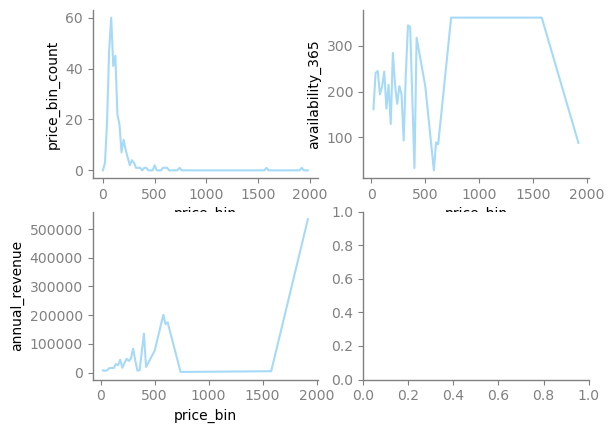

In [23]:
fig, axes = plt.subplots(2, 2)
sns.lineplot(x = brooklyn_price_bin_grouping.index, y = 'price_bin_count', data=staten_island_price_bin_grouping,ax=axes[0,0],color='#A6DAF7')
sns.lineplot(x = brooklyn_price_bin_grouping.index, y = 'availability_365', data=staten_island_price_bin_grouping,ax=axes[0,1],color='#A6DAF7')
sns.lineplot(x = brooklyn_price_bin_grouping.index, y = 'annual_revenue', data=staten_island_price_bin_grouping,ax=axes[1,0],color='#A6DAF7')


Text(0, 0.5, 'Number of Listings')

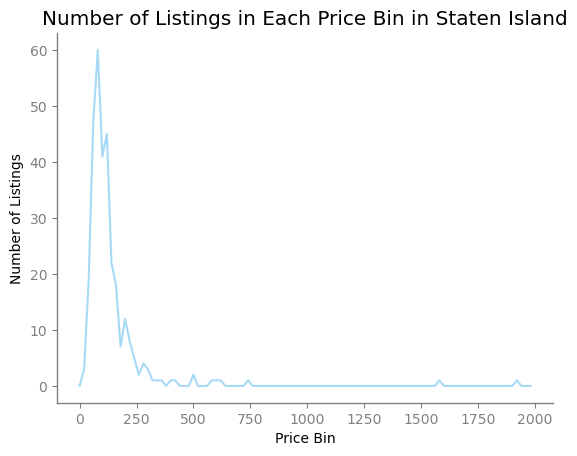

In [24]:
sns.lineplot(x = staten_island_price_bin_grouping.index, y = 'price_bin_count', data=staten_island_price_bin_grouping,color='#A6DAF7')
plt.title('Number of Listings in Each Price Bin in Staten Island')
plt.xlabel('Price Bin')
plt.ylabel('Number of Listings')

Text(0, 0.5, 'Average Days Listing is not booked')

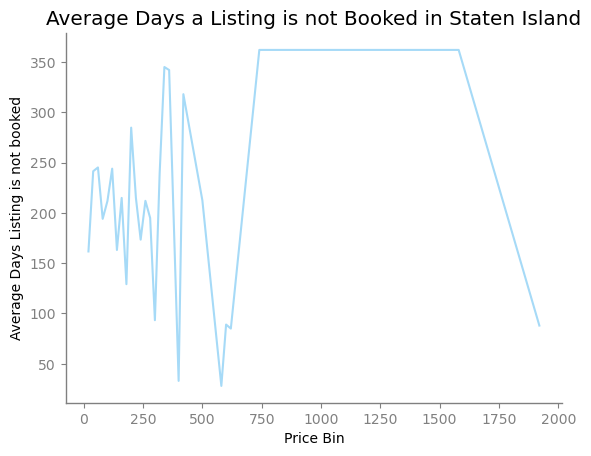

In [25]:
sns.lineplot(x = staten_island_price_bin_grouping.index, y = 'availability_365', data=staten_island_price_bin_grouping,color='#A6DAF7')
plt.title('Average Days a Listing is not Booked in Staten Island')
plt.xlabel('Price Bin')
plt.ylabel('Average Days Listing is not booked')

Text(0, 0.5, 'Estimated Annual Revenue')

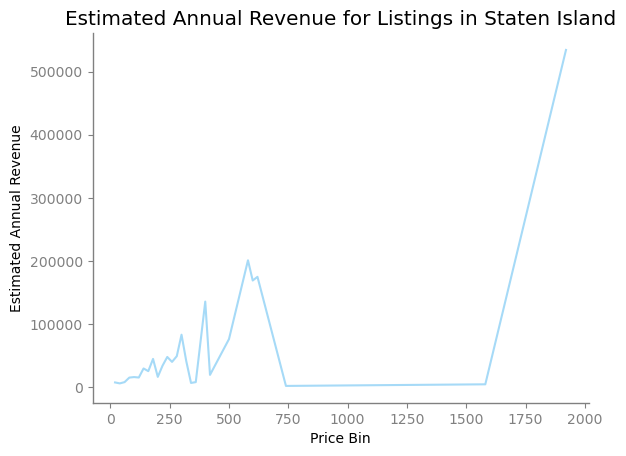

In [26]:
sns.lineplot(x = staten_island_price_bin_grouping.index, y = 'annual_revenue', data=staten_island_price_bin_grouping,color='#A6DAF7')
plt.title('Estimated Annual Revenue for Listings in Staten Island')
plt.xlabel('Price Bin')
plt.ylabel('Estimated Annual Revenue')